In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shapely
import geopandas as gpd
folder = '/home/adelsondias/Repos/educational-analytics/data/'

In [2]:
alunos = pd.read_csv(folder+'alunos.csv')
alunos['serie'] = alunos['serie'].apply(lambda x: x.upper())
alunos = alunos.loc[alunos['etapa'].isin(alunos['etapa'].value_counts()[:5].index)]
alunos['etapa'] = alunos['etapa'].replace({'CEJA ENSINO MEDIO': 'EJA - ENSINO MÉDIO'})
alunos['serie'] = alunos['serie'].replace({'2º PERÍODO (2ª SÉRIE)':'2ª SÉRIE',
 '3º PERÍODO (3ª SÉRIE)':'3ª SÉRIE',
 '1º PERÍODO (1ª SÉRIE)':'1ª SÉRIE'                                 
})
alunos['geometry'] = alunos.apply(lambda x: shapely.geometry.Point([x['longitude'],x['latitude']]), axis=1)
alunos = gpd.GeoDataFrame(alunos)
alunos.head()

,ID,direc,municipio,escola,etapa,serie,turno,turma,disciplina,frequencia,media_final,situacao,latitude,longitude,geometry
0,9599,01ª DIREC - NATAL,NATAL,CE ALFERES TIRADENTES,ENSINO FUNDAMENTAL - ANOS FINAIS,6º ANO,MATUTINO,EFAFM6A,Língua Portuguesa,92.5,6.9,APROVADO,-5.885477,-35.168400,POINT (-35.16840029999999 -5.885477)
1,9595,01ª DIREC - NATAL,NATAL,CE ALFERES TIRADENTES,ENSINO FUNDAMENTAL - ANOS FINAIS,6º ANO,MATUTINO,EFAFM6A,Língua Portuguesa,100.0,6.6,APROVADO,-5.739230,-35.243496,POINT (-35.2434962 -5.739229900000001)
2,9606,01ª DIREC - NATAL,NATAL,CE ALFERES TIRADENTES,ENSINO FUNDAMENTAL - ANOS FINAIS,6º ANO,MATUTINO,EFAFM6A,Língua Portuguesa,100.0,6.1,APROVADO,-5.736580,-35.242956,POINT (-35.2429557 -5.7365805)
3,93948,01ª DIREC - NATAL,NATAL,CE ALFERES TIRADENTES,ENSINO FUNDAMENTAL - ANOS FINAIS,6º ANO,MATUTINO,EFAFM6A,Língua Portuguesa,100.0,7.6,APROVADO,-5.742527,-35.242607,POINT (-35.242607 -5.742527099999999)
4,9582,01ª DIREC - NATAL,NATAL,CE ALFERES TIRADENTES,ENSINO FUNDAMENTAL - ANOS FINAIS,6º ANO,MATUTINO,EFAFM6A,Língua Portuguesa,100.0,7.1,APROVADO,-5.742393,-35.244102,POINT (-35.2441023 -5.742393)


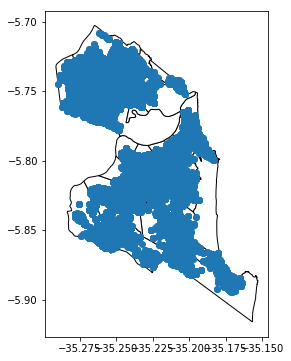

In [3]:
bairros = gpd.read_file(folder+'bairros_natal_populacao2016.geojson')
ab = gpd.sjoin(alunos, bairros, op='within')

fig, ax = plt.subplots(figsize=(4,6))
bairros.plot(ax=ax, color='white', edgecolor='black')
ab.plot(ax=ax)

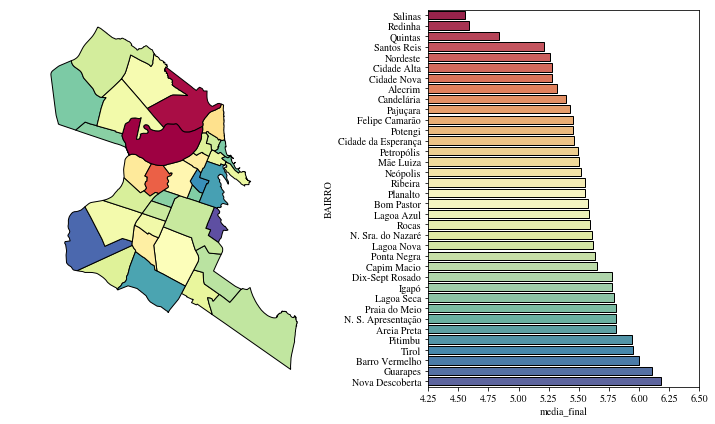

In [93]:
# plt.contour(,z=ab['media_final'])
# X, Y = np.meshgrid(ab['longitude'],ab['latitude'])

fig, ax = plt.subplots(figsize=(10,6),ncols=2)
bairros.set_index('BAIRRO').join(ab.groupby('BAIRRO').mean()['media_final']).drop(['Parque das Dunas']).plot(column='media_final', cmap='Spectral', edgecolor='black',ax=ax[0])
ax[0].axis('off')
sns.barplot(y='BAIRRO',x='media_final',data=ab.groupby('BAIRRO').mean()['media_final'].reset_index().sort_values('media_final'), palette='Spectral', edgecolor='black', linewidth=1)
ax[1].set_xlim([4.25,6.5])
plt.tight_layout()
plt.savefig('mediafinal_bairro.pdf',dpi=200)

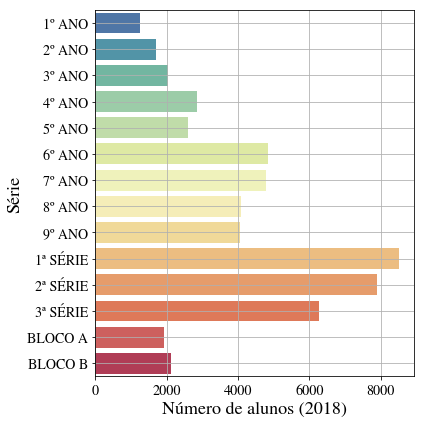

In [4]:
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
fig, ax = plt.subplots(figsize=(6,6))
sns.countplot(y='serie', data=alunos, ax=ax, order=[ 
                                             '1º ANO', '2º ANO', '3º ANO', '4º ANO', '5º ANO', 
                                             '6º ANO', '7º ANO', '8º ANO', '9º ANO',
                                             '1ª SÉRIE', '2ª SÉRIE', '3ª SÉRIE', 'BLOCO A', 'BLOCO B'], palette='Spectral_r')
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.set_ylabel('Série',fontsize=18)
ax.set_xlabel('Número de alunos (2018)',fontsize=18)
ax.grid()
plt.tight_layout()
plt.savefig(folder+'../plots/count_serie.pdf',dpi=200)

In [5]:
from sklearn.preprocessing import LabelEncoder

ab = ab.dropna()
X = ab[['serie','turno','disciplina','frequencia','BAIRRO','REG_ADM','densidade2016']]
y = ab['media_final']

for feature in ['serie', 'turno', 'disciplina','BAIRRO','REG_ADM']:
    X[feature] = LabelEncoder().fit_transform(X[feature])
X.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,serie,turno,disciplina,frequencia,BAIRRO,REG_ADM,densidade2016
0,5,1,0,92.5,26,3,18.24
33,5,1,1,96.8,26,3,18.24
204,6,1,0,63.4,26,3,18.24
224,6,1,1,69.2,26,3,18.24
267,7,1,0,100.0,26,3,18.24


In [8]:
pgrid = {
    'n_estimators': [100, 300],
    'max_depth':[3, 5],
    'max_features':[0.8, 1]
}

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
gs = GridSearchCV(RandomForestRegressor(), param_grid=pgrid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
gs.fit(X,y)
print('Erro médio:', np.sqrt(-gs.best_score_))
gs.best_estimator_

Erro médio: 2.2995710964817904


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features=0.8, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

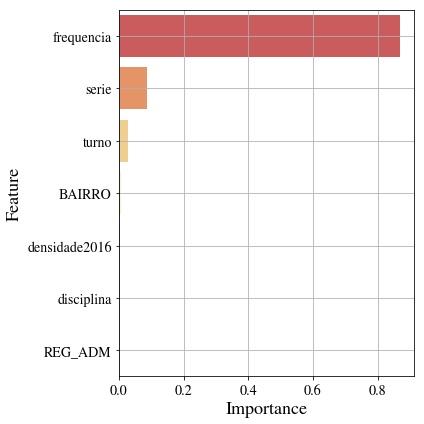

In [10]:
fimp = pd.DataFrame()
fimp['feature'] = X.columns
fimp['importance'] = gs.best_estimator_.feature_importances_

fig, ax = plt.subplots(figsize=(6,6))
sns.barplot(x='importance', y='feature', ax=ax, data=fimp.sort_values('importance',ascending=False),palette='Spectral')
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.set_ylabel('Feature',fontsize=18)
ax.set_xlabel('Importance',fontsize=18)
ax.grid()
plt.tight_layout()
plt.savefig(folder+'../plots/rf_feature_importance.pdf',dpi=200)